In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix, ConfusionMatrixDisplay

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
from tensorflow.keras.utils import to_categorical

import shap

df = pd.read_csv("../../data/csv/cleaned_fix.csv")

2025-06-02 16:00:36.355911: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-06-02 16:00:36.365167: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1748872836.375702  206813 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1748872836.379853  206813 cuda_blas.cc:1407] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
W0000 00:00:1748872836.387961  206813 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking 

In [2]:
df.sort_values(by=['Participant', 'FixNr'], inplace=True)
selected_columns = ["Image", "Scene", "ROI", "FixDur", "Start", "End", "X", "Y", "Participant", "experience"]
df_filtered =  df[selected_columns]

In [3]:
# --- Encode labels ---
label_encoder = LabelEncoder()
y_encoded = label_encoder.fit_transform(df_filtered['experience'])  # 'Label' should be your column with categories
y_onehot = to_categorical(y_encoded)

# --- Normalize features ---
features = df_filtered.drop(columns=['experience', 'Participant'])  # adjust based on your data
scaler = StandardScaler()
X_scaled = scaler.fit_transform(features)

In [4]:
# --- Sliding window function ---
def create_sequences(X, y, window_size):
    X_seq, y_seq = [], []
    for i in range(len(X) - window_size):
        X_seq.append(X[i:i+window_size])
        y_seq.append(y[i+window_size - 1])  # predict last item in window
    return np.array(X_seq), np.array(y_seq)

In [5]:
features.head()

,Image,Scene,ROI,FixDur,Start,End,X,Y
0,1,1,0,103.0,7.0,109.0,510.9,381.0
370,2,1,8,280.0,7.0,286.0,518.3,391.7
644,1,2,4,259.0,7.0,265.0,507.2,403.9
1072,2,2,14,301.0,9.0,309.0,496.3,358.3
1296,1,3,3,267.0,7.0,273.0,505.4,378.2


In [6]:
window_size = 5  # adjust as needed
X_seq, y_seq = create_sequences(X_scaled, y_onehot, window_size)

# --- Train/test split ---
X_train, X_test, y_train, y_test = train_test_split(X_seq, y_seq, test_size=0.2, random_state=42)

In [7]:
# --- LSTM Model ---
model = Sequential([
    LSTM(64, input_shape=(X_train.shape[1], X_train.shape[2])),
    Dense(32, activation='relu'),
    Dense(4, activation='softmax')  # 4 classes
])

model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# --- Train ---
history = model.fit(X_train, y_train, epochs=200, batch_size=32, validation_split=0.1)

Epoch 1/200


W0000 00:00:1748872838.117083  206813 gpu_device.cc:2341] Cannot dlopen some GPU libraries. Please make sure the missing libraries mentioned above are installed properly if you would like to use GPU. Follow the guide at https://www.tensorflow.org/install/gpu for how to download and setup the required libraries for your platform.
Skipping registering GPU devices...
/home/sam/anaconda3/envs/tf310/lib/python3.10/site-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


678/678 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.3116 - loss: 1.3571 - val_accuracy: 0.3841 - val_loss: 1.2949
Epoch 2/200
678/678 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.3858 - loss: 1.2719 - val_accuracy: 0.4044 - val_loss: 1.2331
Epoch 3/200
678/678 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.4173 - loss: 1.2139 - val_accuracy: 0.4305 - val_loss: 1.1901
Epoch 4/200
678/678 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.4604 - loss: 1.1630 - val_accuracy: 0.4716 - val_loss: 1.1382
Epoch 5/200
678/678 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.4921 - loss: 1.1094 - val_accuracy: 0.4849 - val_loss: 1.1024
Epoch 6/200
678/678 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.5154 - loss: 1.0673 - val_accuracy: 0.5180 - val_loss: 1.0647
Epoch 7/200
678/678 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.5408 - loss: 1.0236 - val_accuracy: 0.5326 - val_loss: 1.0319
Epoch 8/200
678/678 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.5693 - loss: 0.9765 - val_accuracy: 0.5479

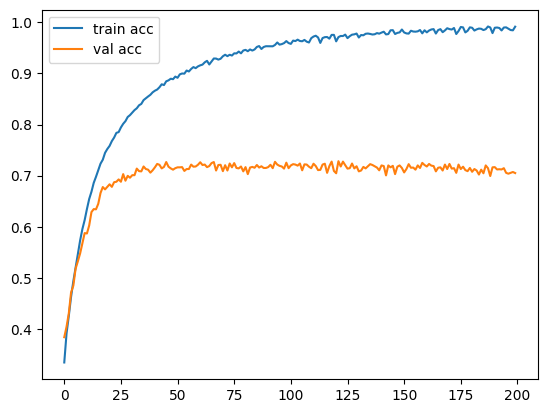

In [8]:
import matplotlib.pyplot as plt

plt.plot(history.history['accuracy'], label='train acc')
plt.plot(history.history['val_accuracy'], label='val acc')
plt.legend()
plt.show()

In [9]:
# --- Evaluate ---
test_loss, test_acc = model.evaluate(X_test, y_test)
print(f"Test Accuracy: {test_acc:.2f}")

189/189 ━━━━━━━━━━━━━━━━━━━━ 0s 880us/step - accuracy: 0.7071 - loss: 2.7952
Test Accuracy: 0.70


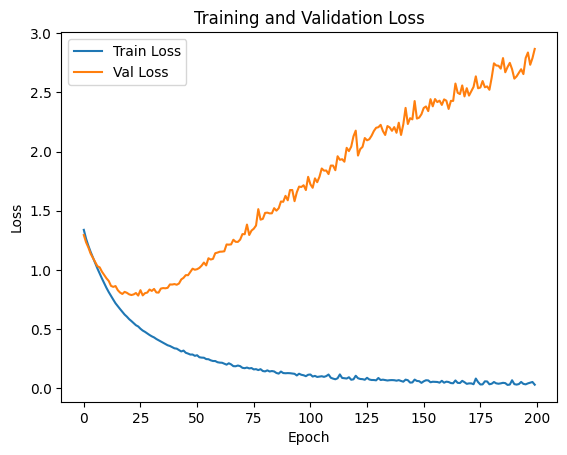

In [10]:
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Val Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.show()

189/189 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


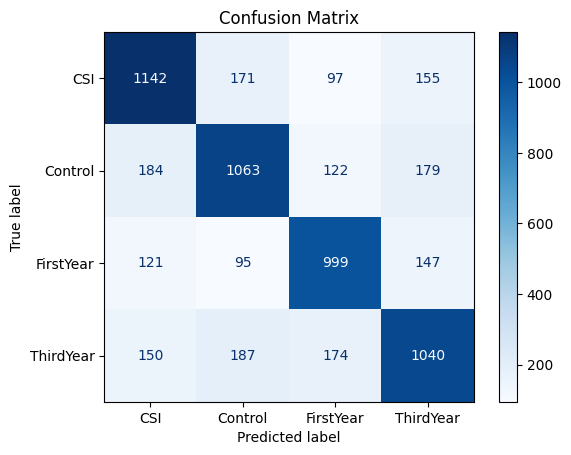

In [11]:
# --- Predict on test set ---
y_pred_probs = model.predict(X_test)                     # Get prediction probabilities
y_pred = np.argmax(y_pred_probs, axis=1)                 # Convert to class indices
y_true = np.argmax(y_test, axis=1)                       # Convert one-hot to class indices

# --- Confusion Matrix ---
cm = confusion_matrix(y_true, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=label_encoder.classes_)
disp.plot(cmap=plt.cm.Blues)
plt.title('Confusion Matrix')
plt.show()


In [12]:
# Print classification report
print("Classification Report:")
print(classification_report(y_true, y_pred, target_names=label_encoder.classes_))

Classification Report:
              precision    recall  f1-score   support

         CSI       0.72      0.73      0.72      1565
     Control       0.70      0.69      0.69      1548
   FirstYear       0.72      0.73      0.73      1362
   ThirdYear       0.68      0.67      0.68      1551

    accuracy                           0.70      6026
   macro avg       0.70      0.71      0.70      6026
weighted avg       0.70      0.70      0.70      6026



In [13]:
X_train.shape

(24104, 5, 8)

In [14]:
# Your LSTM model expects input of shape: (batch_size, timesteps, features)
# Let's assume: X_train.shape == (samples, timesteps, features)

timesteps = X_train.shape[1]
feature_size = X_train.shape[2]

# Flatten over time for KernelExplainer input (required to make it 2D)
background = X_train[:100].mean(axis=1)  # shape: (100, features)

# Define prediction function that reshapes 2D input back to 3D for the LSTM
def predict_fn(x):
    x_reshaped = x.reshape((x.shape[0], 1, feature_size))  # reshape to (batch, 1, features)
    return model.predict(x_reshaped)

explainer = shap.KernelExplainer(predict_fn, background)

# Flatten test samples too
X_test_flat = X_test[:10].mean(axis=1)  # shape: (10, features)

# Explain predictions
shap_values = explainer.shap_values(X_test_flat)


4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 


  0%|                                                    | 0/10 [00:00<?, ?it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
794/794 ━━━━━━━━━━━━━━━━━━━━ 0s 479us/step


 10%|████▍                                       | 1/10 [00:00<00:04,  1.81it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
794/794 ━━━━━━━━━━━━━━━━━━━━ 0s 474us/step


 20%|████████▊                                   | 2/10 [00:01<00:04,  1.86it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
794/794 ━━━━━━━━━━━━━━━━━━━━ 0s 479us/step


 30%|█████████████▏                              | 3/10 [00:01<00:03,  1.89it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
794/794 ━━━━━━━━━━━━━━━━━━━━ 0s 487us/step


 40%|█████████████████▌                          | 4/10 [00:02<00:03,  1.89it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
794/794 ━━━━━━━━━━━━━━━━━━━━ 0s 520us/step


 50%|██████████████████████                      | 5/10 [00:02<00:02,  1.84it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
794/794 ━━━━━━━━━━━━━━━━━━━━ 0s 476us/step


 60%|██████████████████████████▍                 | 6/10 [00:03<00:02,  1.86it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
794/794 ━━━━━━━━━━━━━━━━━━━━ 0s 534us/step


 70%|██████████████████████████████▊             | 7/10 [00:03<00:01,  1.81it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
794/794 ━━━━━━━━━━━━━━━━━━━━ 0s 505us/step


 80%|███████████████████████████████████▏        | 8/10 [00:04<00:01,  1.81it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
794/794 ━━━━━━━━━━━━━━━━━━━━ 0s 472us/step


 90%|███████████████████████████████████████▌    | 9/10 [00:04<00:00,  1.85it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
794/794 ━━━━━━━━━━━━━━━━━━━━ 0s 482us/step


100%|███████████████████████████████████████████| 10/10 [00:05<00:00,  1.85it/s]


In [23]:
# Assume: shap_values has shape (samples, features, classes)
n_classes = shap_values.shape[2]
feature_names = features.columns  # or manually define if needed

for class_idx in range(n_classes):
    print(f"\nTop features for class {label_encoder.classes_[class_idx]}")
    
    # Take absolute SHAP values for the given class and average over samples
    class_shap = np.abs(shap_values[:, :, class_idx]).mean(axis=0)  # shape: (features,)
    
    top_features = pd.Series(class_shap, index=feature_names).sort_values(ascending=False)
    print(top_features)



Top features for class CSI
Start     0.095545
End       0.074697
Scene     0.061840
Image     0.046185
Y         0.041963
ROI       0.041676
X         0.039982
FixDur    0.020689
dtype: float64

Top features for class Control
Scene     0.208118
End       0.163572
Start     0.118713
Image     0.063377
ROI       0.054862
X         0.050469
Y         0.045583
FixDur    0.026368
dtype: float64

Top features for class FirstYear
Start     0.142495
End       0.137020
Scene     0.052045
Image     0.048727
FixDur    0.047522
X         0.037792
Y         0.034638
ROI       0.032728
dtype: float64

Top features for class ThirdYear
Scene     0.168410
End       0.093011
Start     0.087847
ROI       0.044054
Y         0.042049
FixDur    0.038314
Image     0.024324
X         0.017106
dtype: float64


In [22]:
label_encoder.classes_

array(['CSI', 'Control', 'FirstYear', 'ThirdYear'], dtype=object)

In [ ]:
n_classes    # Look at actual values